In [20]:
import pandas as pd
from pathlib import Path
import os

# === PARAMETERS ===
verified_bouts_file = r"C:\Users\labadmin\Documents\Uppsala analyses\clean_bout_verified.xlsx"
respirometry_dir = Path(r"D:\Respirometry\Bumblebee\flying")  # Folder with trace files
BUFFER = 1  # optional time buffer (sec)

# === Load clean bouts ===
bouts_df = pd.read_excel(verified_bouts_file)
bouts_df = bouts_df[bouts_df["is_event_clean"] == "yes"].copy()
bouts_df["BeeID"] = bouts_df["BeeID"].str.strip().str.lower()

# === Function to find respirometry file by bee ID ===
def find_file(bee_id, directory):
    bee_id = bee_id.lower()
    for file in os.listdir(directory):
        if bee_id in file.lower():  # No file extension assumption
            return directory / file
    return None

# === Extract segments ===
results = []

for idx, row in bouts_df.iterrows():
    bee = row["BeeID"]
    start = row["start_respi_s"]
    stop = row["stop_respi_s"]
    event = row["event_type"]

    file_path = find_file(bee, respirometry_dir)
    if not file_path:
        print(f"❌ No file found for {bee}")
        continue

    try:
        trace = pd.read_csv(file_path, sep="\t")
        trace["Seconds"] = pd.to_numeric(trace["Seconds"], errors="coerce")
        trace["CO2"] = pd.to_numeric(trace["CO2"], errors="coerce")
        trace["CO2_ppm"] = trace["CO2"] * 10000

        # Apply buffer
        seg = trace[(trace["Seconds"] >= start - BUFFER) & (trace["Seconds"] <= stop + BUFFER)].copy()
        if seg.empty:
            print(f"⚠️ Empty segment for {bee} bout {idx}")
            continue

        seg["BeeID"] = bee
        seg["event_type"] = event
        seg["bout_index"] = idx
        results.append(seg)

    except Exception as e:
        print(f"❌ Error for {bee}: {e}")
        continue

# === Combine and save ===
if results:
    full_df = pd.concat(results, ignore_index=True)
    full_df.to_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\extracted_clean_bout_co2_data.csv", index=False)
    print("✅ Full CO₂ trace extracted to 'extracted_clean_bout_co2_data.csv'")
else:
    print("❌ No bouts extracted.")

✅ Full CO₂ trace extracted to 'extracted_clean_bout_co2_data.csv'


In [21]:
import pandas as pd

# Load original verified bout sheet (the ground truth)
verified_df = pd.read_excel(r"C:\Users\labadmin\Documents\Uppsala analyses\clean_bout_verified.xlsx")
verified_df = verified_df[verified_df["is_event_clean"] == "yes"].copy()
verified_df["BeeID"] = verified_df["BeeID"].str.strip().str.lower()
verified_df["event_type"] = verified_df["event_type"].str.strip().str.lower()

# Count verified clean bouts per BeeID and event
expected_counts = verified_df.groupby(["BeeID", "event_type"]).size().unstack(fill_value=0)

# Load extracted bouts from CSV
extracted_df = pd.read_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\extracted_clean_bout_co2_data.csv")
extracted_df["BeeID"] = extracted_df["BeeID"].str.strip().str.lower()
extracted_df["event_type"] = extracted_df["event_type"].str.strip().str.lower()

# Count actual extracted unique bouts
actual_counts = extracted_df.groupby(["BeeID", "event_type"])["bout_index"].nunique().unstack(fill_value=0)

# Merge for comparison
comparison = expected_counts.join(actual_counts, lsuffix="_expected", rsuffix="_extracted", how="outer").fillna(0).astype(int)

# Show mismatches
mismatched = comparison[comparison.filter(like="_expected").ne(comparison.filter(like="_extracted")).any(axis=1)]

print("🔍 Mismatched counts (only shown):")
print(mismatched)

🔍 Mismatched counts (only shown):
event_type   buzz_expected  flight_expected  buzz_extracted  flight_extracted
BeeID                                                                        
green3                   6                3               6                 3
green4                  23                4              23                 4
green5                   3               17               3                17
red31                   12                2              12                 2
unmarked3               11                3              11                 3
unmarked303             46                2              46                 2
unmarked34               3                1               3                 1
unmarked38              29                2              29                 2
unmarked4                8               20               8                20
unmarked41               3               10               3                10
unmarked42               2    

In [22]:
import pandas as pd
import numpy as np
from scipy.integrate import trapz

# Load extracted CO₂ data
df = pd.read_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\extracted_clean_bout_co2_data.csv")

# Load temperature metadata
bee_meta = pd.read_excel(r"C:\Users\labadmin\Documents\Uppsala analyses\beeID laser file name + weight.xlsx", sheet_name="flying_bees")
bee_meta["BeeID"] = bee_meta["BeeID"].str.strip().str.lower()

# Merge temperature info
df["BeeID"] = df["BeeID"].str.strip().str.lower()
df = df.merge(bee_meta[["BeeID", "Temperature"]], on="BeeID", how="left")

# Constants
FLOW_RATE = 400  # mL/min
T_N = 23.32258   # Reference temperature for Q10

results = []

# Group by Bee and bout
grouped = df.groupby(["BeeID", "bout_index"])

for (bee_id, bout_idx), group in grouped:
    group = group.sort_values("Seconds")
    t = group["Seconds"].values
    co2 = group["CO2_ppm"].values
    T_a = group["Temperature"].iloc[0]

    if pd.isna(T_a) or len(t) < 2:
        continue

    dt = t[-1] - t[0]
    if dt <= 0:
        continue

    q10 = 10 ** ((T_N - T_a) * (np.log10(2) / 10))
    area_ppm_sec = trapz(co2, t)

    co2_rate = (
        ((area_ppm_sec * q10 / 1e6 * FLOW_RATE) / 60) / dt * 3600 * 1e3
    )

    results.append({
        "BeeID": bee_id,
        "bout_index": bout_idx,
        "event_type": group["event_type"].iloc[0],
        "dt": dt,
        "Temperature": T_a,
        "q10": q10,
        "metabolic_rate_uL_h": co2_rate,
        "metabolic_rate_mL_h": co2_rate / 1000  # ✅ conversion here
    })

# Save result
result_df = pd.DataFrame(results)
result_df.to_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\metabolic_rates_buzz_and_flight.csv", index=False)
print("✅ Metabolic rates saved to 'metabolic_rates_buzz_and_flight.csv'")
result_df.head()

✅ Metabolic rates saved to 'metabolic_rates_buzz_and_flight.csv'


,BeeID,bout_index,event_type,dt,Temperature,q10,metabolic_rate_uL_h,metabolic_rate_mL_h
0,green3,0,buzz,2,23.5,0.987777,6068.014132,6.068014
1,green3,1,buzz,1,23.5,0.987777,6116.896672,6.116897
2,green3,2,buzz,2,23.5,0.987777,6166.889869,6.166890
3,green3,3,buzz,1,23.5,0.987777,6216.883066,6.216883
4,green3,4,buzz,2,23.5,0.987777,6634.283854,6.634284


In [24]:
# Group by Bee and event_type to separate buzzing vs flight
summary_df = (
    result_df
    .groupby(["BeeID", "event_type"])
    .agg(
        n_bouts=("metabolic_rate_mL_h", "count"),
        mean_CO2_mL_h=("metabolic_rate_mL_h", "mean"),
        sd_CO2_mL_h=("metabolic_rate_mL_h", "std"),
        sem_CO2_mL_h=("metabolic_rate_mL_h", lambda x: x.std(ddof=1) / np.sqrt(len(x)))
    )
    .reset_index()
)

# Display summary table
display(summary_df)

,BeeID,event_type,n_bouts,mean_CO2_mL_h,sd_CO2_mL_h,sem_CO2_mL_h
0,green3,buzz,6,6.607642,0.921717,0.376290
1,green3,flight,3,11.552150,0.632427,0.365132
2,green4,buzz,23,13.134396,2.173642,0.453236
3,green4,flight,4,14.690701,0.427336,0.213668
4,green5,buzz,3,11.498541,0.875141,0.505263
5,green5,flight,17,15.521886,2.261153,0.548410
6,red31,buzz,12,12.935100,1.940504,0.560175
7,red31,flight,2,12.933292,1.318176,0.932091
8,unmarked3,buzz,11,12.936428,1.389756,0.419027
9,unmarked3,flight,3,10.700737,1.830038,1.056573


In [42]:
# Load bee metadata with weight
bee_meta = pd.read_excel("C:/Users/labadmin/Documents/Uppsala analyses/beeID laser file name + weight.xlsx")
bee_meta["BeeID"] = bee_meta["BeeID"].str.strip().str.lower()

# Prepare MR dataframe
result_df["BeeID"] = result_df["BeeID"].str.strip().str.lower()

# Merge weight info into result_df
result_df = result_df.merge(bee_meta[["BeeID", "Average weight"]], on="BeeID", how="left")
result_df = result_df.rename(columns={"Average weight": "weight_g"})

# Compute mass-specific metabolic rate (mL CO₂ / g / h)
result_df["mass_specific_mL_g_h"] = result_df["metabolic_rate_mL_h"] / result_df["weight_g"]

In [43]:
summary_df = (
    result_df
    .groupby(["BeeID", "event_type"])
    .agg(
        n_bouts=("mass_specific_mL_g_h", "count"),
        mean_MSMR=("mass_specific_mL_g_h", "mean"),
        sd_MSMR=("mass_specific_mL_g_h", "std"),
        sem_MSMR=("mass_specific_mL_g_h", lambda x: x.std(ddof=1) / np.sqrt(len(x)))
    )
    .reset_index()
)

display(summary_df)

,BeeID,event_type,n_bouts,mean_MSMR,sd_MSMR,sem_MSMR
0,green3,buzz,6,36.506311,5.092361,2.078948
1,green3,flight,3,63.824033,3.494075,2.017305
2,green4,buzz,23,60.666954,10.039916,2.093467
3,green4,flight,4,67.855430,1.973840,0.986920
4,green5,buzz,3,43.146494,3.283832,1.895922
5,green5,flight,17,58.243474,8.484628,2.057824
6,red31,buzz,12,59.064382,8.860750,2.557878
7,red31,flight,2,59.056126,6.019069,4.256125
8,unmarked3,buzz,11,65.834237,7.072549,2.132454
9,unmarked3,flight,3,54.456678,9.313168,5.376960


In [52]:
# Count number of each event type per bee
event_counts = result_df.groupby(["BeeID", "event_type"]).size().unstack(fill_value=0)

# Keep only bees with at least 1 buzz AND 1 flight
valid_bees = event_counts[(event_counts["buzz"] >= 2) & (event_counts["flight"] >= 2)].index

# Filter the result_df
filtered_df = result_df[result_df["BeeID"].isin(valid_bees)].copy()

In [53]:
print("Filtered bees with both buzz & flight:", filtered_df["BeeID"].nunique())
print("Remaining event types per bee:\n")
print(filtered_df.groupby(["BeeID", "event_type"]).size().unstack(fill_value=0))

Filtered bees with both buzz & flight: 21
Remaining event types per bee:

event_type   buzz  flight
BeeID                    
green3          6       3
green4         23       4
green5          3      17
red31          12       2
unmarked3      11       3
unmarked303    46       2
unmarked38     29       2
unmarked4       8      20
unmarked41      3      10
unmarked42      2      24
unmarked44      2       4
unmarked46      4      24
unmarked47     59       3
unmarked48      4      13
unmarked5       2       2
unmarked50      2      26
unmarked501     9      11
unmarked52      2       2
unmarked56      9      23
unmarked57      2      15
unmarked59     22       3


In [54]:
summary_df_filtered = (
    filtered_df
    .groupby(["BeeID", "event_type"])
    .agg(
        n_bouts=("mass_specific_mL_g_h", "count"),
        mean_MSMR=("mass_specific_mL_g_h", "mean"),
        sd_MSMR=("mass_specific_mL_g_h", "std"),
        sem_MSMR=("mass_specific_mL_g_h", lambda x: x.std(ddof=1) / np.sqrt(len(x)))
    )
    .reset_index()
)

display(summary_df_filtered)

,BeeID,event_type,n_bouts,mean_MSMR,sd_MSMR,sem_MSMR
0,green3,buzz,6,36.506311,5.092361,2.078948
1,green3,flight,3,63.824033,3.494075,2.017305
2,green4,buzz,23,60.666954,10.039916,2.093467
3,green4,flight,4,67.855430,1.973840,0.986920
4,green5,buzz,3,43.146494,3.283832,1.895922
5,green5,flight,17,58.243474,8.484628,2.057824
6,red31,buzz,12,59.064382,8.860750,2.557878
7,red31,flight,2,59.056126,6.019069,4.256125
8,unmarked3,buzz,11,65.834237,7.072549,2.132454
9,unmarked3,flight,3,54.456678,9.313168,5.376960


In [72]:
# Save filtered_df to a CSV file
filtered_df.to_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\filtered_df_buzzing_flying.csv", index=False)

print("✅ filtered_df saved as 'filtered_df_buzzing_flying.csv'")


✅ filtered_df saved as 'filtered_df_buzzing_flying.csv'


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Parameters
BUFFER = 1.0  # seconds
respirometry_dir = Path(r"D:\Respirometry\Bumblebee\flying")  # Your trace files
bouts_file = r"C:\Users\labadmin\Documents\Uppsala analyses\clean_bout_verified.xlsx"

def plot_co2_trace_with_bouts_static(bee_id):
    bee_id = bee_id.lower()

    # Load bout metadata
    bouts_df = pd.read_excel(bouts_file)
    bouts_df = bouts_df[bouts_df["is_event_clean"] == "yes"].copy()
    bouts_df["BeeID"] = bouts_df["BeeID"].str.strip().str.lower()
    bouts_df["event_type"] = bouts_df["event_type"].str.strip().str.lower()
    bee_bouts = bouts_df[bouts_df["BeeID"] == bee_id]

    if bee_bouts.empty:
        print(f"⚠️ No clean bouts found for {bee_id}")
        return

    # Locate respirometry file
    trace_file = None
    for f in respirometry_dir.iterdir():
        if bee_id in f.name.lower():
            trace_file = f
            break
    if not trace_file:
        print(f"❌ No trace file found for {bee_id}")
        return

    # Load trace
    trace_df = pd.read_csv(trace_file, sep="\t")
    trace_df["Seconds"] = pd.to_numeric(trace_df["Seconds"], errors="coerce")
    trace_df["CO2_ppm"] = pd.to_numeric(trace_df["CO2"], errors="coerce") * 1e4

    # Plot
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(trace_df["Seconds"], trace_df["CO2_ppm"], label="CO₂ (ppm)", color="black")

    for _, row in bee_bouts.iterrows():
        color = "red" if row["event_type"] == "buzz" else "blue"
        ax.axvspan(
            row["start_respi_s"] - BUFFER,
            row["stop_respi_s"] + BUFFER,
            color=color,
            alpha=0.3,
            label=row["event_type"]
        )

    # Remove duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.set_title(f"CO₂ Trace with Bouts – {bee_id}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("CO₂ concentration (ppm)")
    plt.tight_layout()

    # Save PNG for GitHub rendering
    filename = f"{bee_id}_trace_plot.png"
    plt.savefig(filename, dpi=300)
    plt.show()

    print(f"✅ Static plot saved as {filename}")

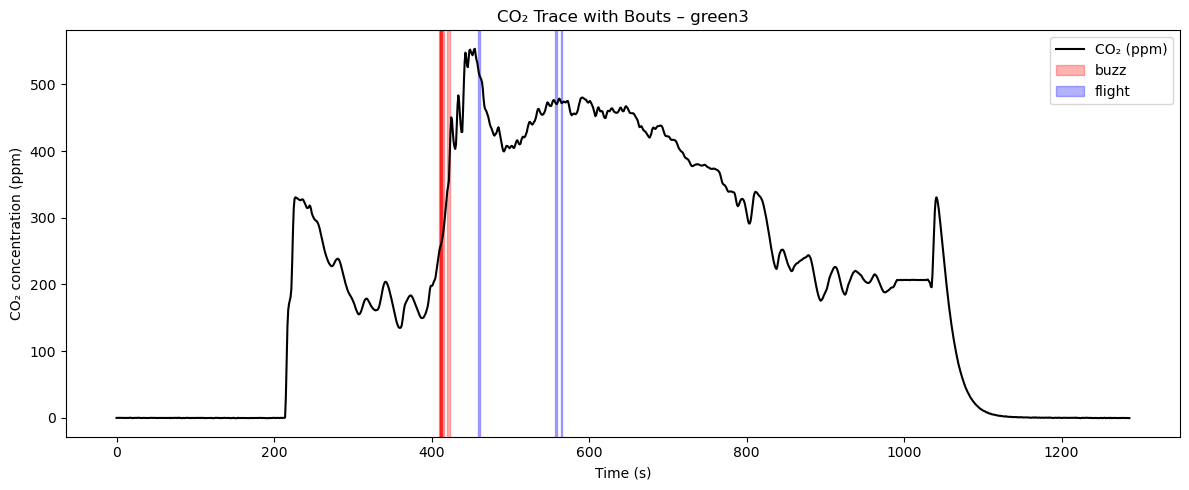

✅ Static plot saved as green3_trace_plot.png


In [36]:
plot_co2_trace_with_bouts_static("green3")

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Parameters
BUFFER = 1.0
respirometry_dir = Path(r"D:\Respirometry\Bumblebee\flying")
bouts_file = r"C:\Users\labadmin\Documents\Uppsala analyses\clean_bout_verified.xlsx"

def plot_zoomed_trace_with_bouts(bee_id, start_time=400, stop_time=600):
    bee_id = bee_id.lower()

    # === Load bout data ===
    bouts_df = pd.read_excel(bouts_file)
    bouts_df = bouts_df[bouts_df["is_event_clean"] == "yes"].copy()
    bouts_df["BeeID"] = bouts_df["BeeID"].str.strip().str.lower()
    bouts_df["event_type"] = bouts_df["event_type"].str.strip().str.lower()
    bee_bouts = bouts_df[bouts_df["BeeID"] == bee_id]

    # Filter bouts within zoom window (+buffer)
    zoom_bouts = bee_bouts[
        (bee_bouts["start_respi_s"] <= stop_time + BUFFER) &
        (bee_bouts["stop_respi_s"] >= start_time - BUFFER)
    ]

    # === Load trace ===
    trace_file = None
    for f in respirometry_dir.iterdir():
        if bee_id in f.name.lower():
            trace_file = f
            break
    if not trace_file:
        print(f"❌ No file found for {bee_id}")
        return

    trace_df = pd.read_csv(trace_file, sep="\t")
    trace_df["Seconds"] = pd.to_numeric(trace_df["Seconds"], errors="coerce")
    trace_df["CO2_ppm"] = pd.to_numeric(trace_df["CO2"], errors="coerce") * 1e4

    zoom_df = trace_df[(trace_df["Seconds"] >= start_time) & (trace_df["Seconds"] <= stop_time)]

    # === Plot ===
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(zoom_df["Seconds"], zoom_df["CO2_ppm"], color="black", label="CO₂ (ppm)")

    for _, row in zoom_bouts.iterrows():
        color = "red" if row["event_type"] == "buzz" else "blue"
        ax.axvspan(
            row["start_respi_s"] - BUFFER,
            row["stop_respi_s"] + BUFFER,
            color=color,
            alpha=0.3,
            label=row["event_type"]
        )

    # Remove duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.set_title(f"{bee_id.upper()} – CO₂ Trace with Bouts ({start_time}-{stop_time}s)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("CO₂ concentration (ppm)")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

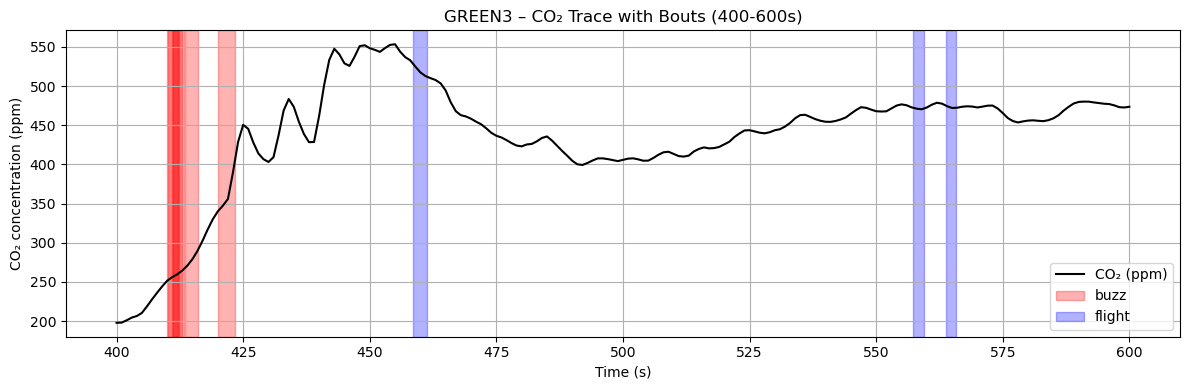

In [41]:
plot_zoomed_trace_with_bouts("green3", 400, 600)

In [100]:
import pandas as pd

# Load data
filtered_df = pd.read_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\filtered_df_buzzing_flying.csv")
bee_meta = pd.read_excel(r"C:\Users\labadmin\Documents\Uppsala analyses\beeID laser file name + weight.xlsx")
its_df = pd.read_excel(r"C:\Users\labadmin\Documents\Uppsala analyses\ITS measurements.xlsx")

# Clean BeeIDs
filtered_df["BeeID_clean"] = filtered_df["BeeID"].str.lower().str.strip()
bee_meta["BeeID_clean"] = bee_meta["BeeID"].str.lower().str.strip()
its_df["ID_clean"] = its_df["ID"].str.lower().str.strip()

# Merge ColonyID
merged_df = pd.merge(filtered_df, bee_meta[["BeeID_clean", "ColonyID"]], on="BeeID_clean", how="left")

# Build ITS mapping: choose the best match (longest exact match in ID_clean)
def find_best_match(bee_id, id_list):
    candidates = [id_ for id_ in id_list if bee_id in id_]
    if not candidates:
        return None
    # Prioritise those ending with the bee_id
    endswith_matches = [id_ for id_ in candidates if id_.endswith(bee_id)]
    return endswith_matches[0] if endswith_matches else candidates[0]

# Build lookup table
bee_ids = filtered_df["BeeID_clean"].unique()
id_map = {
    bee_id: find_best_match(bee_id, its_df["ID_clean"].tolist())
    for bee_id in bee_ids
}
# Filter ITS to only the best matches
its_subset = its_df[its_df["ID_clean"].isin(id_map.values())].copy()
its_subset["BeeID_clean"] = its_subset["ID_clean"].map(
    {v: k for k, v in id_map.items()}
)

# Rename ITS column
its_subset = its_subset[["BeeID_clean", "Length"]].rename(columns={"Length": "ITS_mm"})

# Merge with ITS data
merged_df = pd.merge(merged_df, its_subset, on="BeeID_clean", how="left")

# Drop helper column
merged_df.drop(columns=["BeeID_clean"], inplace=True)

# Export
merged_df.to_csv(r"C:\Users\labadmin\Documents\Uppsala analyses\data\filtered_df_with_colony_and_ITS.csv", index=False)
print("✅ Final data exported to 'filtered_df_with_colony_and_ITS.csv'")

✅ Final data exported to 'filtered_df_with_colony_and_ITS.csv'
